# Question 9 L1 Regularized Logistic Loss Compare Proximal GD with GD

In [10]:
import numpy as np
from numpy import linalg as LA
import collections
from matplotlib import pyplot as plt
verbosity = False
# Utils

def inverse_sigmoid(var):
    '''
    return 1/(1+exp(var))
    avoid large overflow
    '''
    if var>=0:
        return np.exp(-var)/(1+np.exp(-var))
    else:
        return 1/(1+np.exp(var))

def init_weights(m):
    '''
    Generate random weights in [0,1]
    '''
    return np.random.rand(m, 1)

def logistic_loss_vectorized_L1(w, X, y, la):
    '''
    input: w parameter, X variables, y label, la lambda
    Assignment 6.1
    return f as the loss function value and g as the gradient
    '''
    x_mul_w = np.matmul(X, w)
    y_X_w = np.multiply(y, x_mul_w)
    f = np.sum(np.logaddexp(0, -y_X_w)) + la * LA.norm(w, 1)
    inv_sigmoid_vector = np.exp(np.minimum(0, -y_X_w))/(1 + np.exp(np.multiply(-y_X_w,np.sign(y_X_w)))) # n * 1
    y_inv_sigmoid = -1 * np.multiply(y, inv_sigmoid_vector)
    before_reg = np.matmul(y_inv_sigmoid.reshape(1,-1),X)
    g =  before_reg + (la * np.sign(w.T))
    g = g.reshape(-1, 1)
    return (f, g, before_reg.reshape(-1, 1))

# Load data
'''
Copied from https://github.com/rishabhk108/OptimizationML/tree/master/Assignments/data/README.md
'''

from scipy.io import loadmat
import numpy as np
def load_data():
    X = loadmat(r"train.mat")
    y = np.loadtxt(r"train.targets").reshape(-1, 1)
    X = X['X'].todense()
    # print(X.shape)
    # print(y.shape)
    return X,y

def plot(losses, labels):
    fig,ax = plt.subplots()
    for i in range(len(losses)):
        ax.plot(range(1,len(losses[i])+1), losses[i], label=labels[i])
    ax.legend()
    ax.set_xlabel("# Iterations")
    ax.set_ylabel("Loss Function Value")

### Gradient Descent with Fixed Learning rate alpha = 1e-05 ###
## Logistic Loss ##
### Proximal Gradient Descent with Fixed Learning rate alpha = 1e-05 ###
## Logistic Loss ##


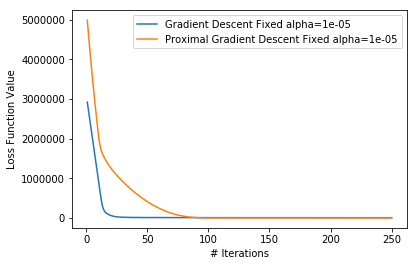

In [12]:
from numpy import linalg as LA

def gradient_descent_fixed_eta(func_obj,w, max_iter, alpha, X, y, la):
    f,g,_ = func_obj(w,X,y,la)
    loss = []
    for cur_iter in range(1, max_iter+1):
        f,g,_ = func_obj(w,X,y,la)
        loss.append(f)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f))
        w = w - alpha * g
    return loss

def gradient_descent_Armijo_v4(func_obj, w, max_iter, alpha, X, y, la, gamma):
    f,g,_ = func_obj(w,X,y,la)
    pre_f = f # last iteration loss
    pre_g = g # last iteration gradient
    alpha = alpha / LA.norm(g, 1) # heuristic alpha
    for cur_iter in range(1, max_iter+1):
        w_tent = w - alpha * g
        f_tent, g_tent, _ = func_obj(w_tent, X, y, la)
        gTg=np.dot(g.T, g)[0,0]
        while f_tent > f - alpha * gamma* gTg: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gTg /(2*(f_tent + alpha* gTg - f))  # Armijo v3 interpolation
            w_tent = w - alpha * g
            f_tent, g_tent, _ = func_obj(w_tent, X, y, la)
        if cur_iter>1:
            alpha = min(1, 2 * (pre_f - f)/gTg)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
                  ", Loss Function Value = " + str(f_tent))
        pre_f = f
        pre_g = g
        f = f_tent
        g = g_tent
        w = w_tent
        
def prox_operator(z, la):
    # prox_{\lambda ||x||_1} = [abs(x)-lambda]_{+} * sign(x)
    soft_threshold = np.maximum(np.abs(z) - la, 0)
    return np.multiply(soft_threshold, np.sign(z))

def proximal_gradient_descent_fixed_eta(func_obj, w, max_iter, alpha, X, y, la):
    # w_{t+1} = prox(w_t - alpha * g)
    f,g,fx = func_obj(w,X,y,la)
    loss = []
    m = w.shape[0]
    for cur_iter in range(1, max_iter+1):
        w = prox_operator(w - alpha * fx, la*alpha)
        f,g,fx = func_obj(w,X,y,la)
        loss.append(f)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
                  ", Loss Function Value = " + str(f))
    return loss

def proximal_gradient_descent_Armijo_v4(func_obj, w, max_iter, alpha, X, y, la, gamma):
    f,g,fx = func_obj(w,X,y,la)
    pre_f = f # last iteration loss
    pre_g = g # last iteration gradient
    pre_fx = fx
    alpha = alpha / LA.norm(g, 1) # heuristic alpha
    for cur_iter in range(1, max_iter+1):
        w_tent = prox_operator(w - alpha * g, la*alpha)
        f_tent,g_tent,fx_tent = func_obj(w_tent,X,y,la)
        gTg=np.dot(g.T, g)[0,0]
        while f_tent > f - alpha * gamma* gTg: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gTg /(2*(f_tent + alpha* gTg - f))  # Armijo v3 interpolation
            w_tent = prox_operator(w - alpha * g, la*alpha)
            f_tent, g_tent, fx_tent = func_obj(w_tent, X, y, la)
        if cur_iter>1:
            alpha = min(1, 2 * (pre_f - f)/gTg)
        print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        pre_f = f
        pre_g = g
        f = f_tent
        g = g_tent
        fx = fx_tent
        w = w_tent
    
def test():
    X,y = load_data()
    m = X.shape[1]
    w = init_weights(m)
    print('''### Gradient Descent with Fixed Learning rate alpha = 1e-05 ###''')
    print('''## Logistic Loss ##''')
    GD_loss = gradient_descent_fixed_eta(logistic_loss_vectorized_L1, w, 250, 0.00001, X, y, 1.0)
    w = init_weights(m)
    print('''### Proximal Gradient Descent with Fixed Learning rate alpha = 1e-05 ###''')
    print('''## Logistic Loss ##''')
    PGD_loss = proximal_gradient_descent_fixed_eta(logistic_loss_vectorized_L1, w, 250, 0.00001, X, y, 1000)
    plot([GD_loss,PGD_loss],['''Gradient Descent Fixed alpha='''+str(1e-05),'''Proximal Gradient Descent Fixed alpha='''+str(1e-05)])

#     w = init_weights(m)
#     print('''### Proximal Gradient Descent with ArmijoV4, gamma=0.0001 ###''')
#     print('''## Logistic Loss ##''')
#     proximal_gradient_descent_Armijo_v4(logistic_loss_vectorized_L1, w, 250, 1, X, y, 1000, 0.0001)
test()